In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import scipy
from scipy import optimize
import os
import sys
import csv
import math
import time
import re
import pickle

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout, GRU, Bidirectional
from tensorflow.keras.optimizers import SGD
from tensorflow.random import set_seed
from tensorflow.keras import backend as K
from keras.layers.preprocessing import preprocessing_utils

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
sys.path.append('/content/gdrive/MyDrive/git/quantumML/python/sdes')
import sde_solve
import sde_systems

sys.path.append('/content/gdrive/MyDrive/git/quantumML/python/systems')
import rabi_weak_meas

sys.path.append('/content/gdrive/MyDrive/git/quantumML/python/models')
import fusion

In [ ]:
import imp
imp.reload(fusion)

<module 'fusion' from '/content/gdrive/MyDrive/git/quantumML/python/models/fusion.py'>

# Data Preprocessing

In [ ]:
# Load large dataset averaged over 10 runs
mint = 0
maxt = 4.0
deltat = 2**(-8)
tvec = np.arange(mint,maxt,deltat)

voltage_dir = '/content/gdrive/MyDrive/Research/QML/models/eps_ZZ00_grp1000_N40_T4_avg10/voltage'
all_probs_dir = '/content/gdrive/MyDrive/Research/QML/models/eps_ZZ00_grp1000_N40_T4_avg10/all_probs'
epsilons_dir = '/content/gdrive/MyDrive/Research/QML/models/eps_ZZ00_grp1000_N40_T4_avg10/epsilons'
voltage = tf.saved_model.load(voltage_dir)
all_probs = tf.saved_model.load(all_probs_dir)
epsilons = tf.cast(tf.saved_model.load(epsilons_dir), dtype=all_probs.dtype)

In [ ]:
# Append true parameter values to probability tensor
all_probs = tf.concat([all_probs, tf.tile(epsilons[:,tf.newaxis,tf.newaxis], multiples=[1,all_probs.shape[1],1])], axis=2)

# Take the average voltage records over groups
voltage = tf.reduce_mean(voltage, axis=1)[...,tf.newaxis]

# Compute the voltage centered differences
voltage_diff = (voltage[:,2:,...] - voltage[:,:-2,...])/(2.0*deltat)
all_probs = all_probs[:,1:-1,:]
tvec = tvec[1:-1]

In [ ]:
# Split the derivatives
train_frac = 0.5
train_x, valid_x, train_y, valid_y = fusion.split_data(voltage_diff.numpy(), all_probs.numpy(), train_frac)
_, _, train_params, valid_params = fusion.split_data(voltage_diff.numpy(), all_probs[...,-1,-1].numpy(), train_frac)

In [ ]:
# Keep the real parts of the data only
train_x = np.real(train_x)
train_y = np.real(train_y)
valid_x = np.real(valid_x)
valid_y = np.real(valid_y)

print(train_x.shape)
print(train_y.shape)
print(train_params.shape)
print(valid_x.shape)
print(valid_y.shape)
print(valid_params.shape)

(20, 1022, 2, 1)
(20, 1022, 43)
(20,)
(20, 1022, 2, 1)
(20, 1022, 43)
(20,)


# Train the Encoder Direct from Known Parameters

In [ ]:
# Build CNN model
_, seq_len, num_features, grp_size = train_x.shape
num_params = 1
num_epochs = 75
conv_sizes = [32]
encoder_sizes = [100, 50]
avg_size = 20

# Starting with ZZ00 initial condition
rho0 = np.zeros([4,4], dtype=float)
rho0[0,0] = 1.0

# Set the parameter values
params = np.array([1.395,2.0*0.83156,0.1469,0.1], dtype=np.double)

model = fusion.build_fusion_cnn_model(seq_len, num_features, grp_size, avg_size, conv_sizes, encoder_sizes, num_params, rho0, params, deltat)

# Remove the physical and parameter layers for this test
model.pop()
model.pop()
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 average_pooling2d (AverageP  (None, 1003, 2, 1)       0         
 ooling2D)                                                       
                                                                 
 conv2d (Conv2D)             (None, 492, 1, 32)        1312      
                                                                 
 average_pooling2d_1 (Averag  (None, 473, 1, 32)       0         
 ePooling2D)                                                     
                                                                 
 flatten (Flatten)           (None, 15136)             0         
                                                                 
 dense (Dense)               (None, 100)               1513700   
                                                                 
 dense_1 (Dense)             (None, 50)                5

In [ ]:
# Compile the model
loss_func = fusion.param_loss
fusion.compile_model(model, loss_func)

In [ ]:
# Keras train
verbose_level = 1
mini_batch_size = 20

lrscheduler = tf.keras.callbacks.LearningRateScheduler(tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=5e-3,
    decay_steps=1,
    decay_rate=0.99))

history = model.fit(train_x, train_params[:,tf.newaxis], batch_size=mini_batch_size, epochs=num_epochs,
                    validation_data=(valid_x, valid_params[:,tf.newaxis]), verbose=verbose_level, shuffle=True,
                    callbacks=[lrscheduler])

Epoch 1/75
1/1 [==============================] - 2s 2s/step - loss: 1.3337 - val_loss: 0.9703 - lr: 0.0050
Epoch 2/75
1/1 [==============================] - 0s 193ms/step - loss: 1.0491 - val_loss: 0.2145 - lr: 0.0049
Epoch 3/75
1/1 [==============================] - 0s 208ms/step - loss: 0.2313 - val_loss: 0.4438 - lr: 0.0049
Epoch 4/75
1/1 [==============================] - 0s 219ms/step - loss: 0.4202 - val_loss: 0.1845 - lr: 0.0049
Epoch 5/75
1/1 [==============================] - 0s 184ms/step - loss: 0.1659 - val_loss: 0.0762 - lr: 0.0048
Epoch 6/75
1/1 [==============================] - 0s 162ms/step - loss: 0.0766 - val_loss: 0.1811 - lr: 0.0048
Epoch 7/75
1/1 [==============================] - 0s 174ms/step - loss: 0.1940 - val_loss: 0.0802 - lr: 0.0047
Epoch 8/75
1/1 [==============================] - 0s 184ms/step - loss: 0.0837 - val_loss: 0.0282 - lr: 0.0047
Epoch 9/75
1/1 [==============================] - 0s 186ms/step - loss: 0.0220 - val_loss: 0.0980 - lr: 0.0046
Epoc

1/1 [==============================] - 0s 37ms/step


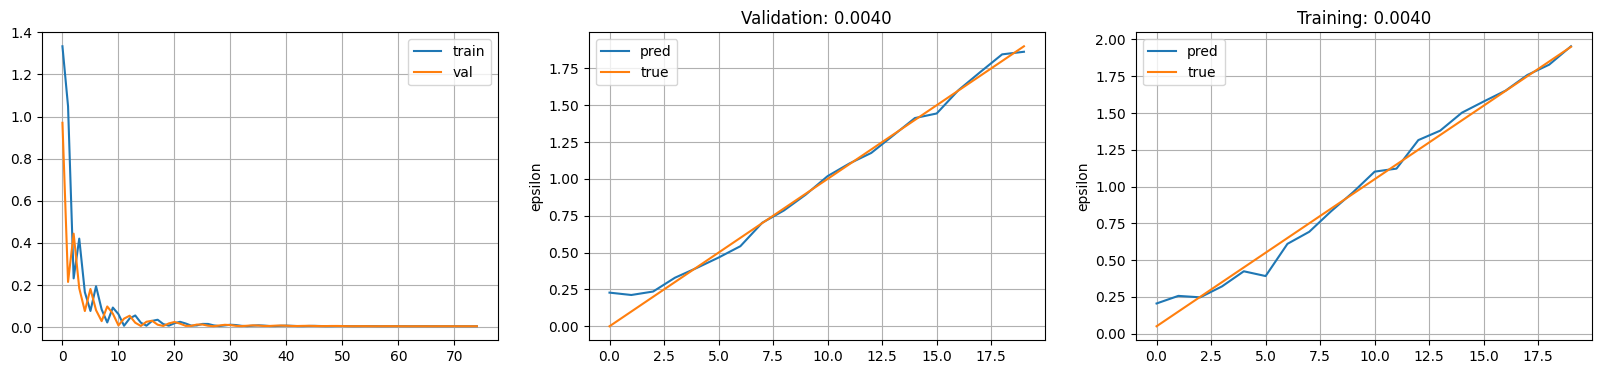

In [ ]:
# Plot the results
plt.figure(figsize=(20,4))

plt.subplot(1,3,1)

plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='val')
plt.legend()
plt.grid();

plt.subplot(1,3,2)
model_out = model.predict(valid_x)
plt.plot(model_out + 1.0e-8, label='pred');
plt.plot(valid_params, label='true')
plt.grid()
plt.legend()
plt.title('Validation: %.4f' % (fusion.param_loss(valid_params[:,tf.newaxis], model_out).numpy()))
plt.ylabel('epsilon');

plt.subplot(1,3,3)
model_out = model.predict(train_x)
plt.plot(model_out + 1.0e-8, label='pred');
plt.plot(train_params, label='true')
plt.grid();
plt.legend()
plt.title('Training: %.4f' % (fusion.param_loss(train_params[:,tf.newaxis], model_out).numpy()))
plt.ylabel('epsilon');

# Train Using Strong Measurement Probabilities

In [ ]:
# Build CNN model
_, seq_len, num_features, grp_size = train_x.shape
num_params = 1
num_epochs = 75
conv_sizes = [32]
encoder_sizes = [100, 50]
avg_size = 20

# Starting with ZZ00 initial condition
rho0 = np.zeros([4,4], dtype=float)
rho0[0,0] = 1.0

# Set the parameter values
params = np.array([1.395,2.0*0.83156,0.1469,0.1], dtype=np.double)

model = fusion.build_fusion_cnn_model(seq_len, num_features, grp_size, avg_size, conv_sizes, encoder_sizes, num_params, rho0, params, deltat)

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 average_pooling2d_2 (Averag  (None, 1003, 2, 1)       0         
 ePooling2D)                                                     
                                                                 
 conv2d_1 (Conv2D)           (None, 492, 1, 32)        1312      
                                                                 
 average_pooling2d_3 (Averag  (None, 473, 1, 32)       0         
 ePooling2D)                                                     
                                                                 
 flatten_1 (Flatten)         (None, 15136)             0         
                                                                 
 dense_2 (Dense)             (None, 100)               1513700   
                                                                 
 dense_3 (Dense)             (None, 50)               

In [ ]:
# Compile the model
loss_func = fusion.fusion_mse_loss_2d
metric_func = fusion.param_metric
fusion.compile_model(model, loss_func, metrics=[metric_func])

1/1 [==============================] - 13s 13s/step


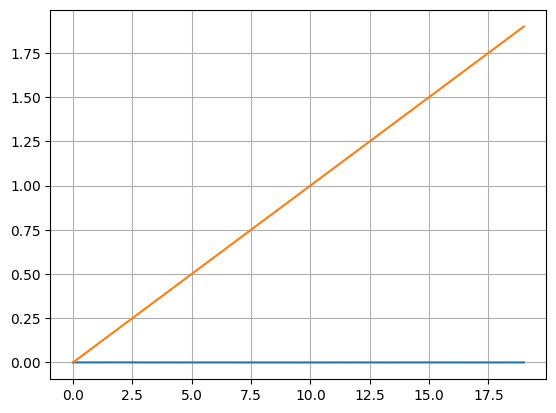

In [ ]:
# View initial parameters
model_out = model.predict(valid_x)
plt.plot(model_out[:,0,-1] + 1.0e-8)
plt.plot(valid_params)
plt.grid();

In [ ]:
print('Initial validation loss: %.5f' % (loss_func(valid_y, model_out)))
print('Initial validation metric: %.5f' % (metric_func(valid_y, model_out)))

Initial validation loss: 0.00543
Initial validation metric: 1.11128


2.193450927734375e-05


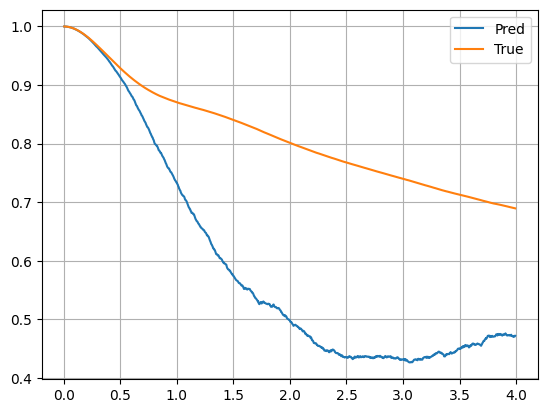

In [ ]:
# View initial probability as a sanity check
plt.plot(tvec, model_out[-1,:,4], label='Pred')
plt.plot(tvec, valid_y[-1,:,4], label='True')
plt.legend()
plt.grid();
print(model_out[-1,-1,-1])

In [ ]:
# Keras train
verbose_level = 1
mini_batch_size = 20
num_epochs = 75

lrscheduler = tf.keras.callbacks.LearningRateScheduler(tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=5e-3,
    decay_steps=1,
    decay_rate=0.99))

history = model.fit(train_x, train_y, batch_size=mini_batch_size, epochs=num_epochs,
                    validation_data=(valid_x, valid_y), verbose=verbose_level, shuffle=True,
                    callbacks=[lrscheduler])

Epoch 1/75
1/1 [==============================] - 49s 49s/step - loss: 0.0057 - param_metric: 1.1543 - val_loss: 0.0053 - val_param_metric: 1.0962 - lr: 0.0050
Epoch 2/75
1/1 [==============================] - 24s 24s/step - loss: 0.0058 - param_metric: 1.1389 - val_loss: 0.0051 - val_param_metric: 1.0446 - lr: 0.0049
Epoch 3/75
1/1 [==============================] - 17s 17s/step - loss: 0.0056 - param_metric: 1.0861 - val_loss: 0.0044 - val_param_metric: 0.8992 - lr: 0.0049
Epoch 4/75
1/1 [==============================] - 20s 20s/step - loss: 0.0047 - param_metric: 0.9369 - val_loss: 0.0019 - val_param_metric: 0.5654 - lr: 0.0049
Epoch 5/75
1/1 [==============================] - 17s 17s/step - loss: 0.0020 - param_metric: 0.5897 - val_loss: 0.0011 - val_param_metric: 0.4252 - lr: 0.0048
Epoch 6/75
1/1 [==============================] - 18s 18s/step - loss: 9.8908e-04 - param_metric: 0.3957 - val_loss: 0.0026 - val_param_metric: 0.6791 - lr: 0.0048
Epoch 7/75
1/1 [====================

1/1 [==============================] - 5s 5s/step


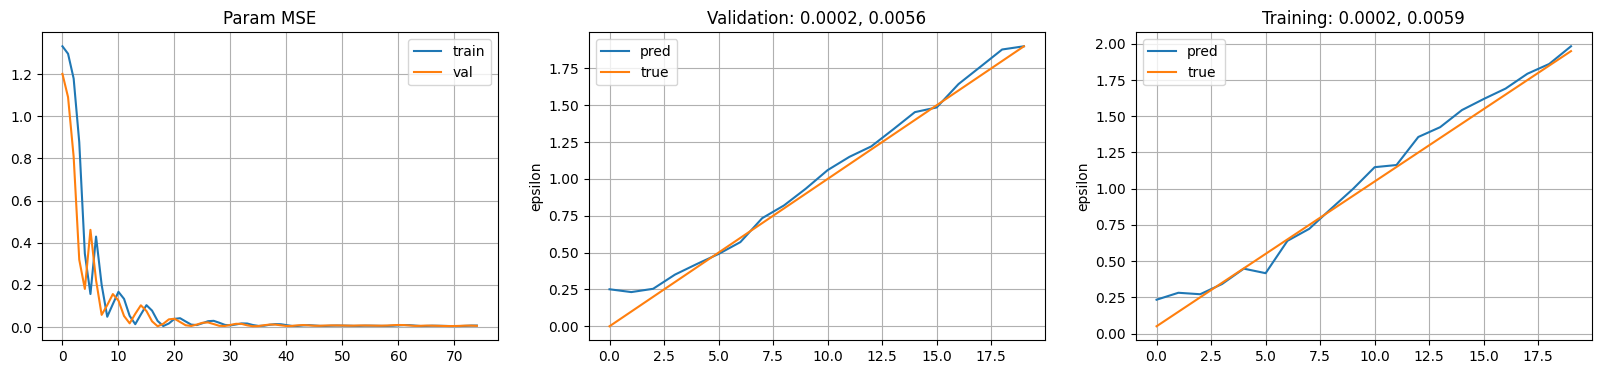

In [22]:
# Plot the results
plt.figure(figsize=(20,4))

plt.subplot(1,3,1)

plt.plot(np.array(history.history['param_metric'])**2, label='train')
plt.plot(np.array(history.history['val_param_metric'])**2, label='val')
plt.legend()
plt.title('Param MSE')
plt.grid();

plt.subplot(1,3,2)
model_out = model.predict(valid_x)
plt.plot(model_out[:,-1,-1] + 1.0e-8, label='pred');
plt.plot(valid_params, label='true')
plt.grid()
plt.legend()
plt.title('Validation: %.4f, %.4f' % (loss_func(valid_y, model_out), fusion.param_loss(valid_params[:,tf.newaxis], model_out[:,-1,-1][:,tf.newaxis] + 1.0e-8).numpy()))
plt.ylabel('epsilon');

plt.subplot(1,3,3)
model_out = model.predict(train_x)
plt.plot(model_out[:,-1,-1] + 1.0e-8, label='pred');
plt.plot(train_params, label='true')
plt.grid();
plt.legend()
plt.title('Training: %.4f, %.4f' % (loss_func(train_y, model_out), fusion.param_loss(train_params[:,tf.newaxis], model_out[:,-1,-1][:,tf.newaxis] + 1.0e-8).numpy()))
plt.ylabel('epsilon');